## Prédiction de concentration ozone 

L'objectif dans ce notebook est de développer des modèles de régression afin de prédire la concentration en ozone à partir de données météorologiques et de la concentration de la veille.  \
J'effectue alors une analyse de données rapide, puis j'entraîne deux modèles de régréssion de référence qui sont dans ce cas : un modèle de **Facebook Prophet** et un deuxième de **Random Forest Regressor**.
<!-- Ensuite, je passe à l'etape de réseaux de neuronnes ou j'introduis un modèle de deux couches (512, 256). -->

In [1]:
# !pip install pystan~=2.14
# !pip install fbprophet

In [2]:
## Data handling modules and libraries

import pandas as pd 
import numpy as np 

## Visualization modules and libraries 
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns
from pandas.plotting import scatter_matrix

## models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, roc_curve, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.metrics import AUC
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor


## utils  
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv("Data/ozone_complet.csv", sep= ';')
df.head()

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,Ne18,Vdir6,Vvit6,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v
19950401,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,8.0,270.0,2.0,290.0,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2
19950402,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,0.0,100.0,2.0,160.0,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6
19950403,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,3.0,310.0,2.0,20.0,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2
19950404,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,8.0,20.0,3.0,10.0,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8
19950405,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,7.0,330.0,2.0,340.0,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1464 entries, 19950401 to 20020930
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   maxO3   1391 non-null   float64
 1   T6      1463 non-null   float64
 2   T9      1463 non-null   float64
 3   T12     1463 non-null   float64
 4   T15     1463 non-null   float64
 5   T18     1463 non-null   float64
 6   Ne6     1462 non-null   float64
 7   Ne9     1462 non-null   float64
 8   Ne12    1462 non-null   float64
 9   Ne15    1462 non-null   float64
 10  Ne18    1459 non-null   float64
 11  Vdir6   1463 non-null   float64
 12  Vvit6   1463 non-null   float64
 13  Vdir9   1463 non-null   float64
 14  Vvit9   1463 non-null   float64
 15  Vdir12  1463 non-null   float64
 16  Vvit12  1463 non-null   float64
 17  Vdir15  1463 non-null   float64
 18  Vvit15  1463 non-null   float64
 19  Vdir18  1463 non-null   float64
 20  Vvit18  1463 non-null   float64
 21  Vx      1463 non-null   fl

Nous observons la présence de données manquantes dans plusieurs champs du dataset du départ : 
- Les deux colonnes 'maxO3' et 'maxO3v' avec un total de 73 instances non remplies pour chacune des deux. 
- Ne6, Ne9, Ne12, Ne15, Ne18. 

### Traitement des données manquantes 

Afin de traiter le problème des données manquantes j'utilise une méthode d'interpolation linéaire pour remplir les gaps de données dans les deux champs 'maxO3', je complète les instances manquantes de la variable 'maxO3v' par le premier lag de la variable 'max03'.\
Pour les quelques valeurs manquantes des champs restants, j'utilise simplement un fillna par la valeur médiane.

In [5]:
## use interpolate to fill missing values 
df['maxO3'] = df['maxO3'].interpolate()

## fill the according maxO3v values with the first lag 
df['maxO3v'] = df['maxO3v'].fillna(df['maxO3'].shift())

## fill other missing values with the median value 
median = df.median()
df.fillna(median, inplace= True)


### Visualisation

En observant les valeurs de l'index du dataframe, il apparait qu'il s'agit des dates correspondantes aux observations. Nous pouvons dans un premier lieu transformer ces valeurs pour créer une colonne date, qui nous sera utile pour la création de différents visuels

In [6]:
df['date'] = df.index 
df['date'] = pd.to_datetime(df['date'] , format= '%Y%m%d'  )
df['year'] = df['date'].dt.year


In [7]:
## plot the annual concentration of ozone between 1995 and 2002

import plotly.graph_objects as go 
from plotly.subplots import make_subplots
dates = [str(e) for e in range(1995,2003)]

fig = make_subplots(rows = 4, cols = 2 )
c = 0
r = 0
for year in dates : 
    dff = df[(df['date'] >= f"{year}-01-01") & (df['date'] <=f'{year}-12-31' )]
    fig.append_trace(go.Scatter(x= dff['date'], 
                            y= dff['maxO3'], name = f"tracé de l'année {year}" )
                              , row =( r // 2 )  + 1, col =c+1 )
    c = (c + 1 ) %  2 
    r = (r + 1 )

    
fig.show()

En analysant les tracés des séries temporelles entre l'année 1995 et l'année 2002, il est difficile d'extraire directement une composante de saisonnalité visible. 

Nous pouvons remarque l'effet de l'interpolation sur les données, notamment dans l'an 1997 ou le gap de données est le plus grand. 

In [8]:
## plot the histogram of the target (maxO3) column 

px.histogram(df, x= 'maxO3' , title= 'maxO3 histogram' )

<AxesSubplot: >

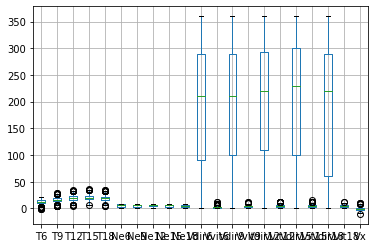

In [9]:
df_boxplot = df[df.columns[1:-3]]
df_boxplot.boxplot(figsize = (10,6))

In [10]:
df[['T6','T9','Vvit6','Vvit9','Vvit12','Vvit15','Vvit18','Vx']].describe()

,T6,T9,Vvit6,Vvit9,Vvit12,Vvit15,Vvit18,Vx
count,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000,1464.000000
mean,12.256148,16.349317,2.491120,3.756831,4.530738,4.812842,4.401639,-0.708658
std,3.898871,4.110926,1.606098,1.892792,2.066002,2.069985,1.760786,3.450061
min,-1.600000,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,-10.392300
25%,9.900000,13.800000,1.000000,2.000000,3.000000,3.000000,3.000000,-3.064200
50%,12.600000,16.600000,2.000000,4.000000,4.000000,5.000000,4.000000,-1.026100
75%,15.000000,19.000000,3.000000,5.000000,6.000000,6.000000,6.000000,1.532100
max,21.700000,28.600000,12.000000,12.000000,12.000000,16.000000,12.000000,10.832900


Sans compréhension des significations de ces attributs, il est difficile de dire s'il s'agit réellement d'outliers. Ainsi, je décide pour ce qui suit de garder les variables intactes et ne pas effectuer de transformations. 

### Etude de corrélation

<AxesSubplot: >

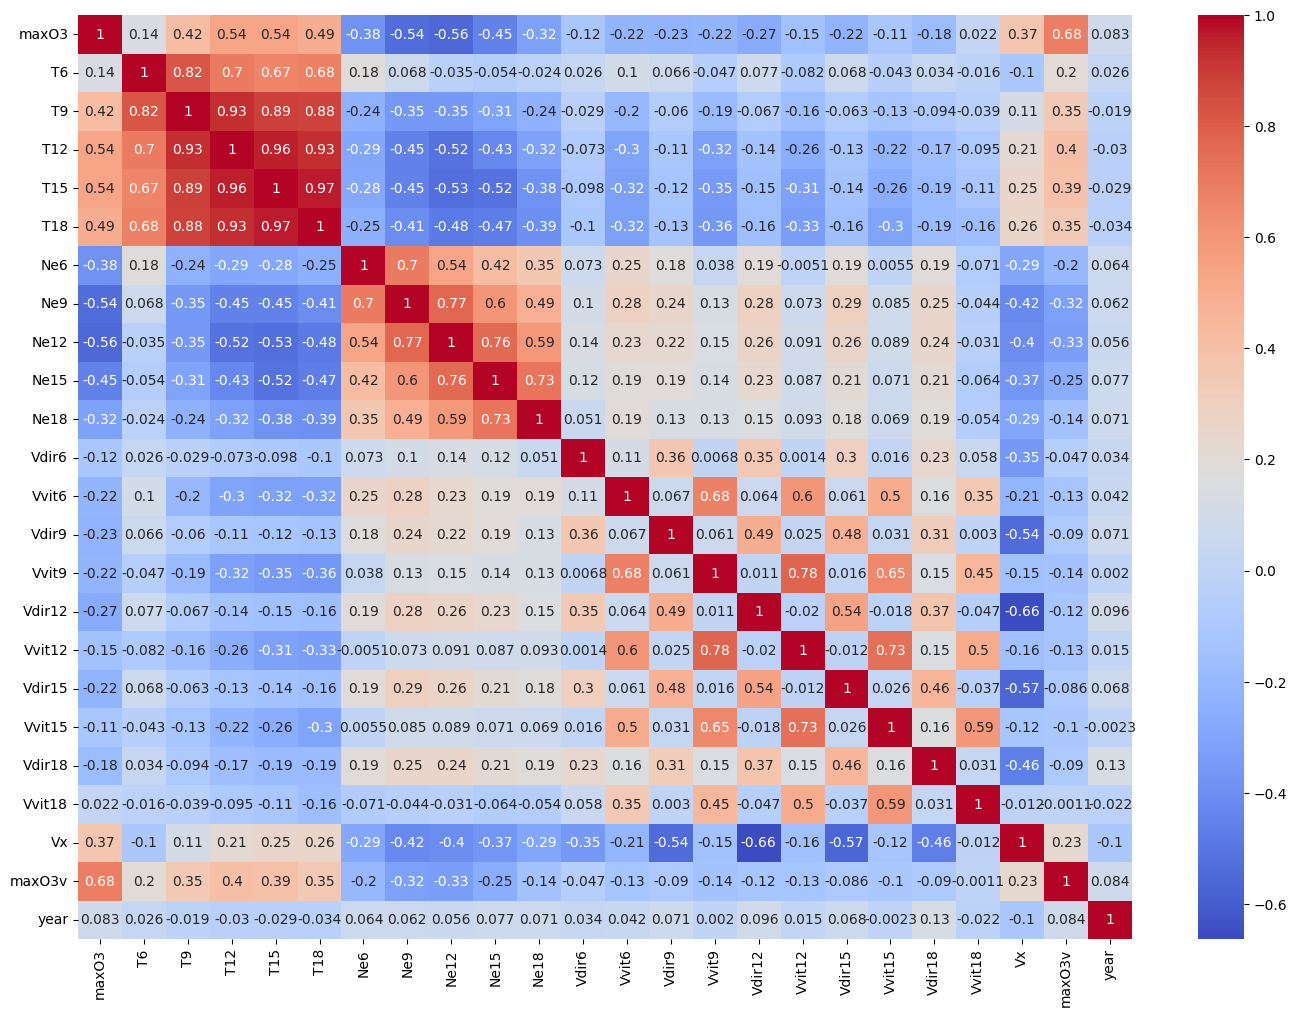

In [11]:
## plot correlation matrix 
corr = df.corr()

# Create a figure with a specific size
fig, ax = plt.subplots(figsize=(17, 12))

# Plot the correlation matrix as a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)

In [12]:
## drop features that have a correlation above 80% 

upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.85)]
print(to_drop) 


['T12', 'T15', 'T18']


Certaines colonnes affichent des corrélations très élevées, c'est l'exemples de : 
- T9, T12, T15 et T18.

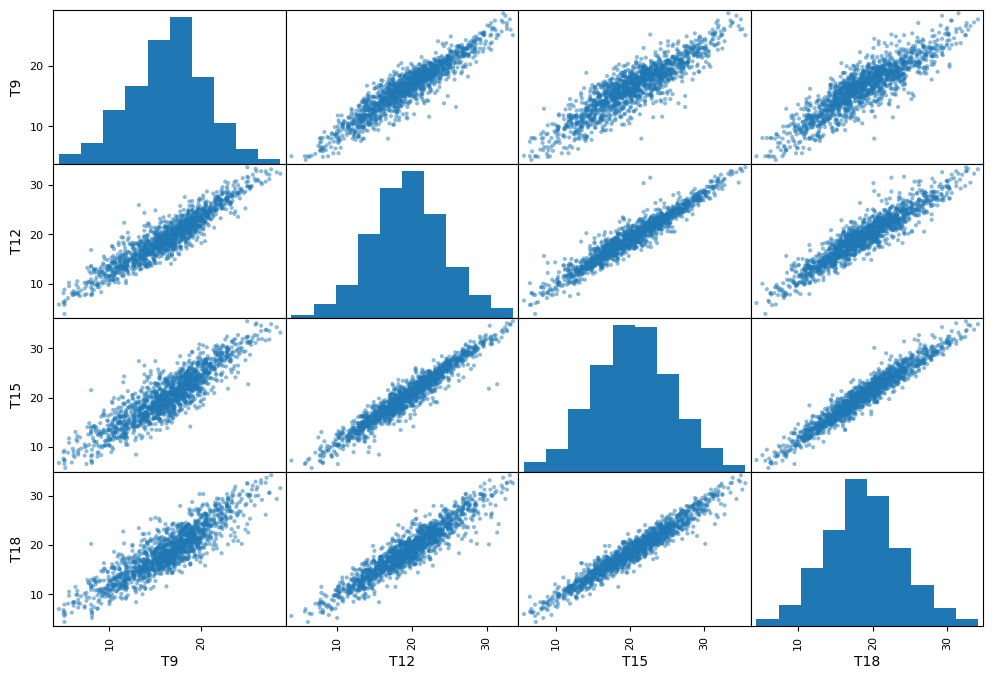

In [13]:
## Plot scatter_matrix of selected variables
attributes = ['T9' , 'T12', "T15", 'T18']
scatter_matrix(df[attributes] , figsize= (12,8))
plt.show()

In [14]:
df.drop(['T12' ,'T15', 'T18'], axis = 1 ,inplace= True)

### Diviser les données en échantillons de train, de validation et de test

In [15]:
dfa = df.sort_values(by= 'date')
dfa = df.drop('date' , axis = 1, errors = 'ignore')


In [20]:
## split data to train, validation and test dataset

train = dfa[dfa['year'].isin([1995, 1996, 1997, 1998, 1999, 2000])].drop('year', axis = 1)
valid =  dfa[dfa['year'] == 2001].drop('year', axis = 1) 
test = dfa[dfa['year'] == 2002 ].drop('year', axis = 1) 

dfa= dfa.drop('year', axis = 1)

In [21]:
X_train, y_train = train.drop("maxO3", axis =1), train['maxO3']
X_valid, y_valid = valid.drop("maxO3", axis =1), valid['maxO3']
X_test, y_test = test.drop("maxO3", axis =1), test['maxO3']


In [22]:
features = dfa.columns 
 
std_scaler = StandardScaler()

X_train_scaled = pd.DataFrame(std_scaler.fit_transform(X_train))
X_valid_scaled = pd.DataFrame(std_scaler.transform(X_valid))
X_test_scaled = pd.DataFrame(std_scaler.transform(X_test))

X_train_scaled.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.557174,-1.150837,1.040653,1.108789,1.128953,1.215000,1.250794,0.708577,-0.293249,0.906045,0.116407,0.952310,-0.256114,1.231267,-0.386721,-1.348317,-0.212940,-0.808343,-0.915214
1,-0.708860,-1.676260,1.040653,1.108789,0.708183,-2.122260,-1.766776,-0.794753,-0.293249,-0.311856,-0.926980,-0.179944,-0.737645,-0.848071,-1.826108,1.385590,-1.347929,0.174396,-1.541401
2,-2.200443,-2.010621,-0.320845,-0.045922,-1.395672,-1.287945,-0.635188,1.062302,-0.293249,-1.623441,-0.926980,1.329727,-1.700705,-0.305635,-1.346313,-0.105632,-0.780434,0.077374,-1.172551
3,-0.708860,-1.413549,1.040653,0.723885,0.708183,0.797842,1.250794,-1.502203,0.325957,-1.717126,0.116407,1.424082,-0.737645,1.321673,-0.866517,1.385590,-0.212940,0.026621,-0.932370
4,-0.633017,-1.341900,1.040653,0.723885,1.128953,1.215000,0.873598,1.239164,-0.293249,1.374468,-0.926980,0.763601,-1.700705,1.050455,-0.866517,1.385590,-0.212940,-0.104984,-1.404155


### Modèles de base : Prophet et RandomForest Regressor

#### Prophet 

In [ ]:
serie = df.sort_values(by ='date')[['date','maxO3']]

## consider a sample for better visualization 
serie_sample = serie[serie.date > '2002-01-01' ].sort_index()

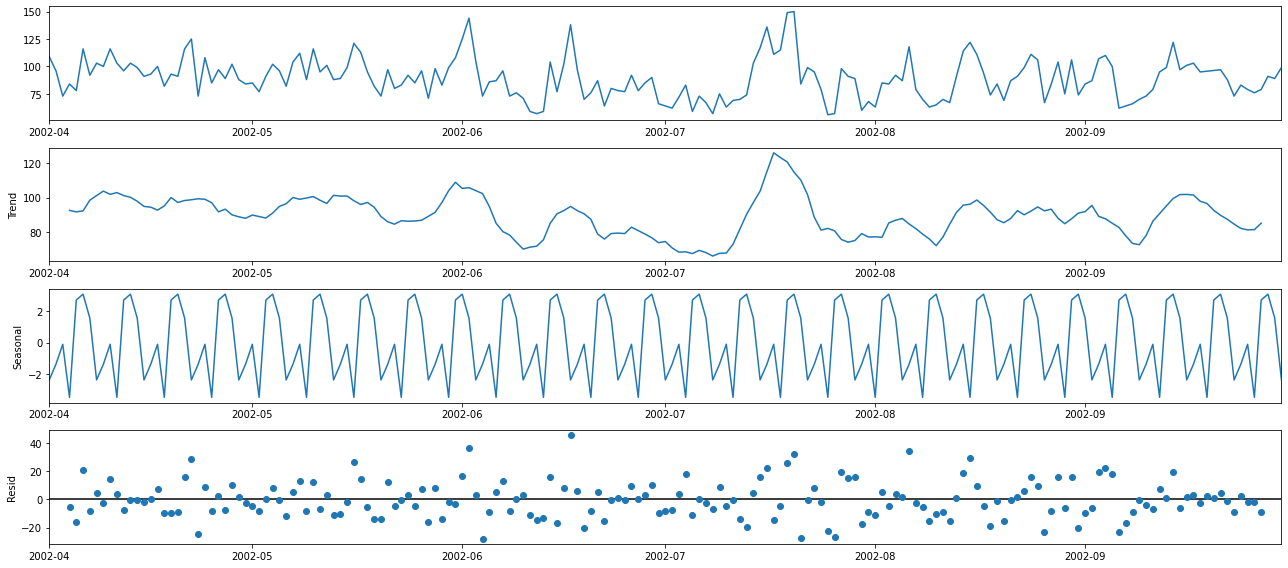

In [ ]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(serie_sample.set_index('date'), model='additive')
fig = decomposition.plot()
plt.show()

En analysant les tracés de la décomposition  de la série temporelle, nous pouvons remarquer une periodicité de 7 jours. Cette information confirme la présence d'une saisonnalité hebdomadaire dans nos séries temporelles. 

Contrairement aux parties qui vont suivre, nous n'allons pas considérer un set de validation. Ainsi, je considère les données historiques entre l'année 1995 et 2001 comme données d'entrainement, et je test la performance sur l'année 2002. 

In [ ]:

serie_train = serie[serie.date < '2002-01-01']
serie_test = serie[serie.date >= '2002-01-01']

serie_train.columns= ['ds' , 'y']
serie_test.columns = ['ds', 'y']

In [38]:
from fbprophet import Prophet

prophet = Prophet(interval_width = 0.95)
prophet.fit(serie_train)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [39]:
test_pred  = np.array(prophet.predict(serie_test)['yhat'])
train_pred = np.array(prophet.predict(serie_train)['yhat'])
# calculate root mean squared error
trainScore = (mean_squared_error(train_pred,
                                  np.array(serie_train['y']))) ** 0.5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = (mean_squared_error(np.array(serie_test['y']),
                                 test_pred)) ** 0.5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.58 RMSE
Test Score: 19.32 RMSE


Text(0.5, 1.0, 'Training data : Predicted data vs Original Data')

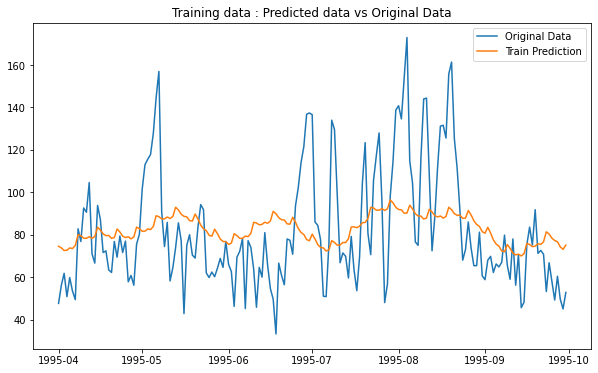

In [40]:
## plot 1 year of training set 
fig = plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(serie_train[(serie_train['ds'] >= '1995-01-01' ) 
 & (serie_train['ds'] < '1996-01-01') ]['ds'],
          serie_train[(serie_train['ds'] >= '1995-01-01' ) 
 & (serie_train['ds'] < '1996-01-01') ]['y'], 
         label='Original Data')

l= len(serie_train[(serie_train['ds'] >= '1995-01-01' ) 
 & (serie_train['ds'] < '1996-01-01') ]['ds'])
# Plot the train predictions
plt.plot(serie_train[(serie_train['ds'] >= '1995-01-01' ) 
 & (serie_train['ds'] < '1996-01-01') ]['ds'], 
         train_pred[:l], 
         label='Train Prediction')

plt.legend()
plt.title('Training data : Predicted data vs Original Data')

Text(0.5, 1.0, 'Test data : Predicted data vs Original Data')

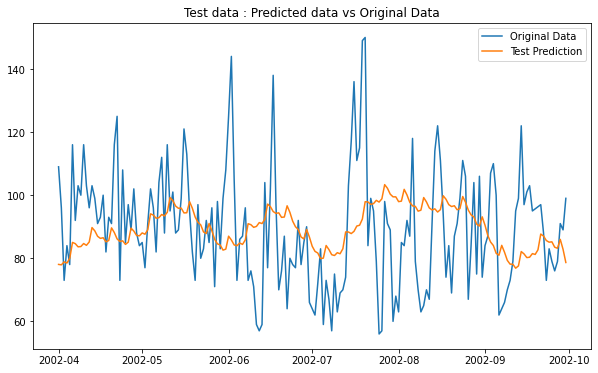

In [42]:
## plot the prediction 
fig = plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(serie_test['ds'],
          serie_test['y'], 
         label='Original Data')

# Plot the train predictions
plt.plot(serie_test['ds'], 
         test_pred, 
         label='Test Prediction'
         )

plt.legend()
plt.title('Test data : Predicted data vs Original Data')

#### Random Forest Regressor

In [23]:

rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)


RandomForestRegressor()

In [24]:
train_pred = rf.predict(X_train_scaled)
test_pred  = rf.predict(X_test_scaled)

# calculate root mean squared error
trainScore = (mean_squared_error(y_train,
                                  train_pred)) ** 0.5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = (mean_squared_error(y_test,
                                 test_pred)) ** 0.5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.81 RMSE
Test Score: 12.77 RMSE


Text(0.5, 1.0, 'Training data : Predicted data vs Original Data')

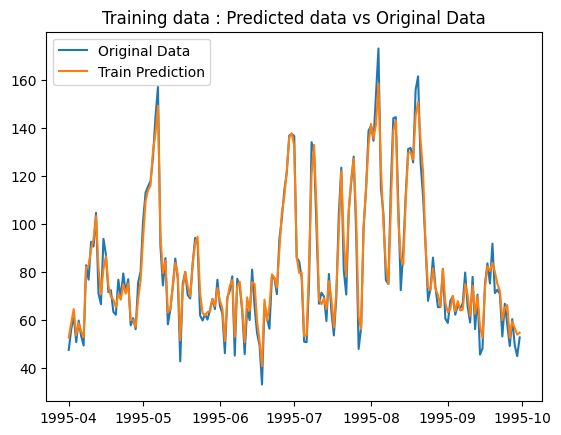

In [25]:
## plot 1 year of training set 
# fig = plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(df[df['year'].isin([1995])]['date'],
          df[df['year'].isin([1995])]['maxO3'], 
         label='Original Data')

l= len(df[df['year'].isin([1995])]['date'])
# Plot the train predictions
plt.plot(df[df['year'].isin([1995])]['date'], 
         train_pred[:l], 
         label='Train Prediction'
         )

plt.legend()

plt.title('Training data : Predicted data vs Original Data')

Text(0.5, 1.0, 'Test data : Predicted data vs Original Data')

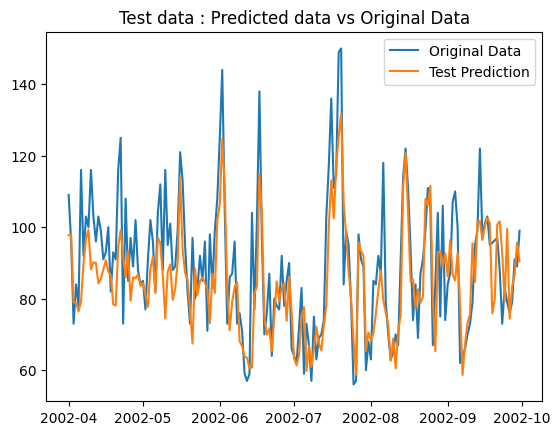

In [26]:
## plot the prediction 
# fig = plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(df[df['year'].isin([2002])]['date'],
          df[df['year'].isin([2002])]['maxO3'], 
         label='Original Data')

# Plot the train predictions
plt.plot(df[df['year'].isin([2002])]['date'], 
         test_pred, 
         label='Test Prediction'
         )


plt.legend()

plt.title('Test data : Predicted data vs Original Data')

### Modèle de réseau de neuronnes simple : 

In [27]:
## trainin a neural network model 

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(Dense(1))
model.summary()
model.compile(loss='mse',
            optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               10240     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 141,825
Trainable params: 141,825
Non-trainable params: 0
_________________________________________________________________


In [28]:
# create the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
## fit the model 
history=model.fit(X_train_scaled,y_train,batch_size=32,
                    epochs=100,verbose=1, callbacks= early_stopping, 
                    shuffle=False,
                    validation_data=(X_valid_scaled, y_valid)).history

Epoch 1/100
35/35 [==============================] - 1s 5ms/step - loss: 5141.4473 - val_loss: 2125.2422
Epoch 2/100
35/35 [==============================] - 0s 2ms/step - loss: 637.5381 - val_loss: 395.0742
Epoch 3/100
35/35 [==============================] - 0s 2ms/step - loss: 414.5457 - val_loss: 343.8950
Epoch 4/100
35/35 [==============================] - 0s 2ms/step - loss: 362.2245 - val_loss: 321.5895
Epoch 5/100
35/35 [==============================] - 0s 2ms/step - loss: 327.0923 - val_loss: 306.3009
Epoch 6/100
35/35 [==============================] - 0s 2ms/step - loss: 303.1585 - val_loss: 293.6938
Epoch 7/100
35/35 [==============================] - 0s 2ms/step - loss: 284.6668 - val_loss: 283.4039
Epoch 8/100
35/35 [==============================] - 0s 2ms/step - loss: 269.6638 - val_loss: 274.8711
Epoch 9/100
35/35 [==============================] - 0s 2ms/step - loss: 257.0142 - val_loss: 268.2050
Epoch 10/100
35/35 [==============================] - 0s 2ms/step - los

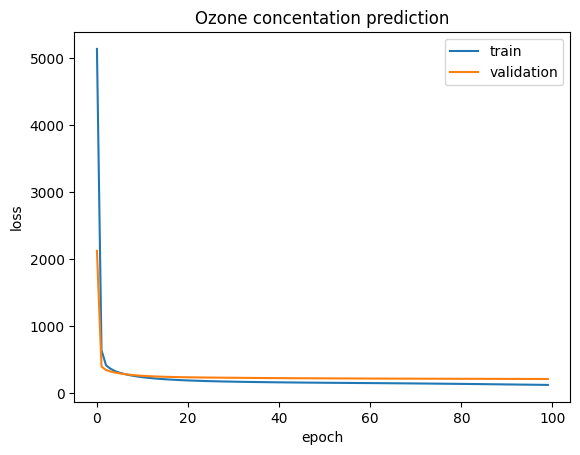

In [29]:
# plot the loss on train and validation data
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Ozone concentation prediction')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right') 

In [ ]:
train_pred = model.predict(X_train_scaled)
test_pred  = model.predict(X_test_scaled)

# calculate root mean squared error
trainScore = (mean_squared_error(y_train,
                                  train_pred)) ** 0.5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = (mean_squared_error(y_test,
                                 test_pred)) ** 0.5
print('Test Score: %.2f RMSE' % (testScore))


6/6 [==============================] - 0s 1ms/step
Train Score: 11.82 RMSE
Test Score: 13.60 RMSE


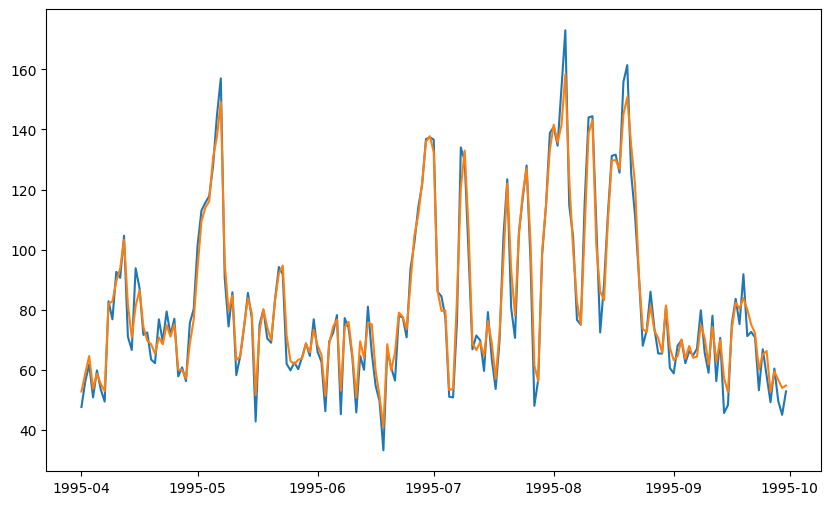

In [30]:
## plot 1 year of training set 
fig = plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(df[df['year'].isin([1995])]['date'],
          df[df['year'].isin([1995])]['maxO3'], 
         label='Original Data')

l= len(df[df['year'].isin([1995])]['date'])
# Plot the train predictions
plt.plot(df[df['year'].isin([1995])]['date'], 
         train_pred[:l], 
         label='Train Prediction'
         )

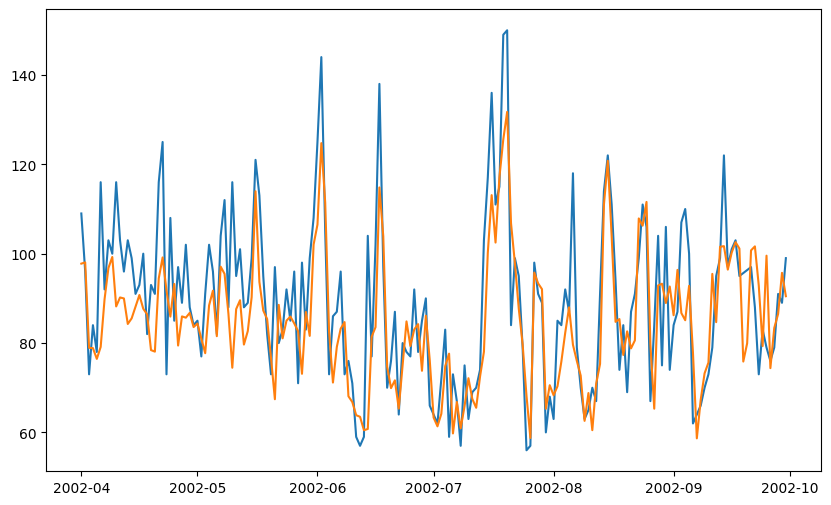

In [31]:
## plot the prediction 
fig = plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(df[df['year'].isin([2002])]['date'],
          df[df['year'].isin([2002])]['maxO3'], 
         label='Original Data')

# Plot the train predictions
plt.plot(df[df['year'].isin([2002])]['date'], 
         test_pred, 
         label='Train Prediction'
         )

### Modèle de LSTM 

Dans cette partie, j'utilise plutôt une normalisation min-max qui a permis de retrouver de meilleurs résultats. 

In [32]:
 
min_max_scaler = MinMaxScaler()
X_train_mscaled = min_max_scaler.fit_transform(X_train)
X_valid_mscaled = min_max_scaler.transform(X_valid)
X_test_mscaled=  min_max_scaler.transform(X_test)



La valeur du window a été choisie manuellement  après différent essais, si la composante de saisonalité était de 7, les résultats du modèle avec la valeur de window égale à 10 ont été meilleurs.

In [33]:
# Specify the number of time steps to use as input (window_size) and output (prediction_steps)
window = 10
prediction_steps = 1

def lstm_data(df,window_size, prediction_steps) :
    # Create input and output arrays for the LSTM network
    input_data = []
    output_data = []
    for i in range(df.shape[0] - window_size - prediction_steps + 1):
        input_data.append(df.iloc[i:i+window_size, 0:-1].values)
        output_data.append(df.iloc[i+window_size-1:i+window_size+prediction_steps-1, -1].values)
    input_data = np.array(input_data)
    output_data = np.array(output_data)

    return input_data, output_data



In [34]:
X_train_mscaled = pd.DataFrame(X_train_mscaled)
X_train_mscaled[19] = y_train.tolist()

X_valid_mscaled = pd.DataFrame(X_valid_mscaled)
X_valid_mscaled[19] = y_valid.tolist()

X_test_mscaled = pd.DataFrame(X_test_mscaled)
X_test_mscaled[19] = y_test.tolist()

In [35]:
X_train_lstm, y_train_lstm = lstm_data(X_train_mscaled,window,prediction_steps)
X_valid_lstm, y_valid_lstm = lstm_data(X_valid_mscaled,window,prediction_steps)
X_test_lstm, y_test_lstm = lstm_data(X_test_mscaled,window,prediction_steps)


print(X_train_lstm.shape)
print(X_valid_lstm.shape)
print(X_test_lstm.shape)
print('-----')
print(y_train_lstm.shape)
print(y_valid_lstm.shape)
print(y_test_lstm.shape)

(1088, 10, 19)
(173, 10, 19)
(173, 10, 19)
-----
(1088, 1)
(173, 1)
(173, 1)


In [36]:

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences = False ))
# model.add(Dropout(0.3))
# model.add(LSTM(90, return_sequences= False) )
# model.add(Dropout(0.5))
# model.add(LSTM(128, return_sequences= False) )
# model.add(Dropout(0.5))
# model.add(Dense(64))
# model.add(Dropout(0.3))
model.add(Dense(y_train_lstm.shape[1]))
model.compile(optimizer='adam', loss='mse')

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               75776     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 75,905
Trainable params: 75,905
Non-trainable params: 0
_________________________________________________________________


In [37]:
# create the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# Train the LSTM model
history = model.fit(X_train_lstm, y_train_lstm, epochs= 300, batch_size=1, callbacks=early_stopping ,
          validation_data=(X_valid_lstm, y_valid_lstm)).history

Epoch 1/300
1088/1088 [==============================] - 4s 2ms/step - loss: 1475.5487 - val_loss: 671.4931
Epoch 2/300
1088/1088 [==============================] - 2s 2ms/step - loss: 543.9353 - val_loss: 660.3395
Epoch 3/300
1088/1088 [==============================] - 2s 2ms/step - loss: 544.7333 - val_loss: 655.6785
Epoch 4/300
1088/1088 [==============================] - 2s 2ms/step - loss: 544.3755 - val_loss: 650.6331
Epoch 5/300
1088/1088 [==============================] - 2s 2ms/step - loss: 523.7676 - val_loss: 587.5162
Epoch 6/300
1088/1088 [==============================] - 2s 2ms/step - loss: 401.3707 - val_loss: 539.8811
Epoch 7/300
1088/1088 [==============================] - 2s 2ms/step - loss: 319.5312 - val_loss: 371.9512
Epoch 8/300
1088/1088 [==============================] - 2s 2ms/step - loss: 299.6677 - val_loss: 449.6716
Epoch 9/300
1088/1088 [==============================] - 2s 2ms/step - loss: 284.8040 - val_loss: 302.0647
Epoch 10/300
1088/1088 [============

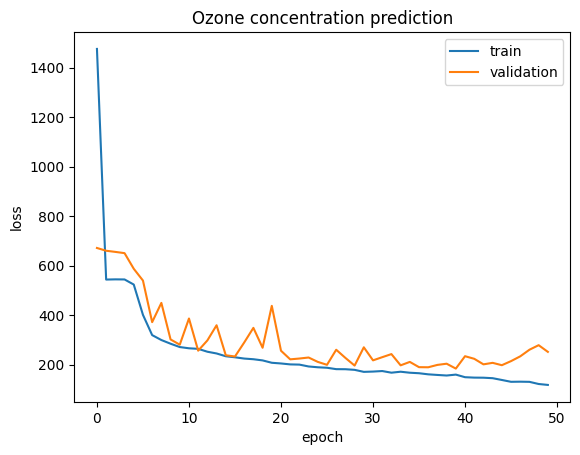

In [38]:
# plot the loss on train and validation data
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Ozone concentration prediction')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right') 

In [39]:
trainPredict = model.predict(X_train_lstm)
validPredict = model.predict(X_valid_lstm)
testPredict = model.predict(X_test_lstm)

6/6 [==============================] - 0s 2ms/step


In [40]:

# calculate root mean squared error
trainScore = (mean_squared_error(y_train_lstm,
                                  trainPredict)) ** 0.5
print('Train Score: %.2f RMSE' % (trainScore))
testScore = (mean_squared_error(y_test_lstm,
                                 testPredict)) ** 0.5
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.21 RMSE
Test Score: 15.44 RMSE


Text(0.5, 1.0, 'Train data : Prediction vs Original Data')

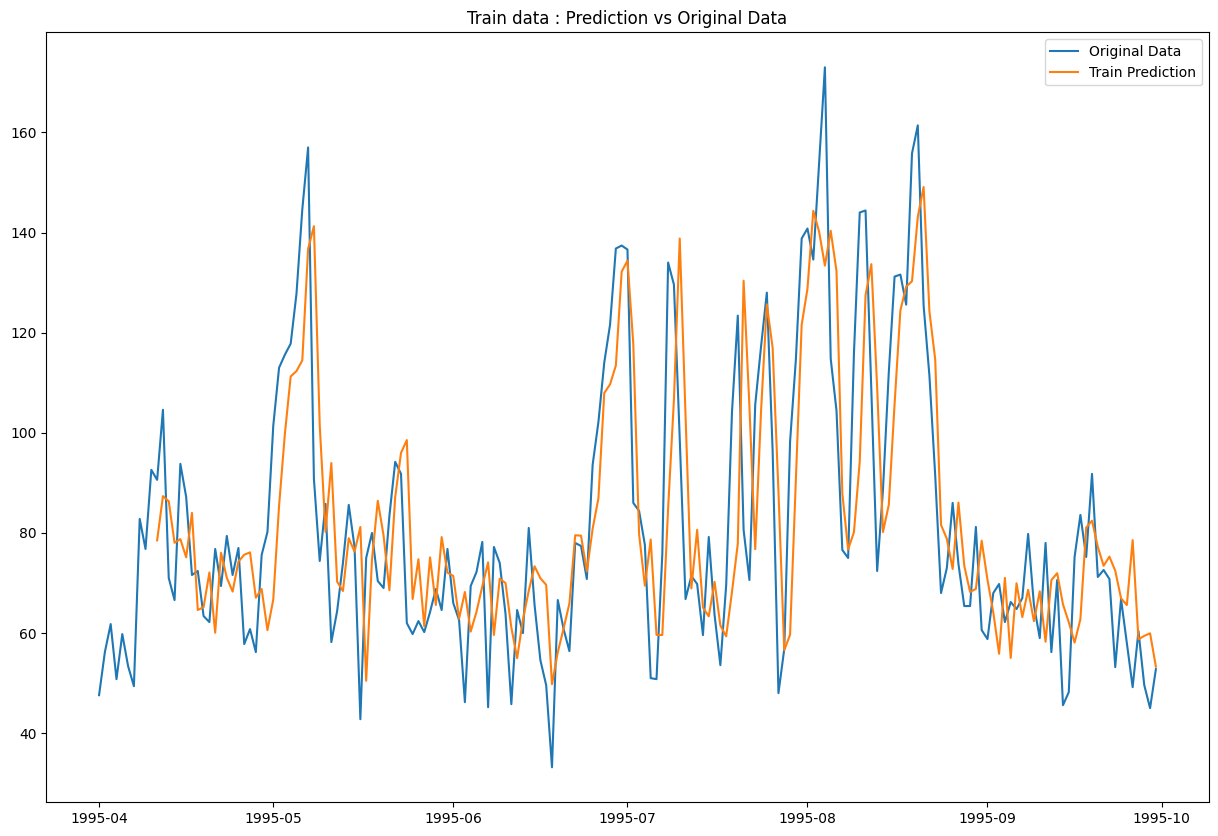

In [41]:
## plot 1 year of training set 
fig = plt.figure(figsize=(15, 10))

# Plot the original data
plt.plot(df[df['year'].isin([1995])]['date'],
          df[df['year'].isin([1995])]['maxO3'], 
         label='Original Data')


# Plot the train predictions
l = len(df[df['year'].isin([1995])])

plt.plot(df[df['year'].isin([1995])]['date'][window:l], 
         trainPredict[:l-window], 
         label='Train Prediction'
         )

plt.legend()
plt.title('Train data : Prediction vs Original Data')

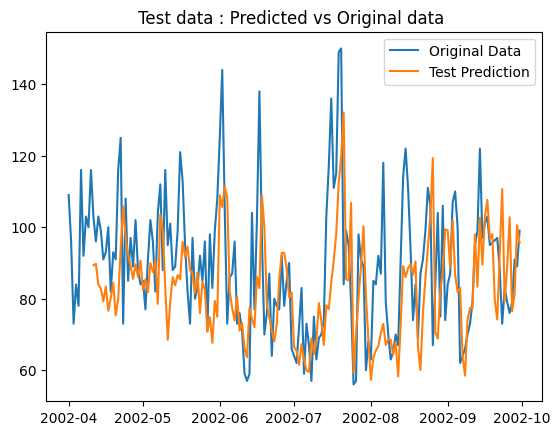

In [42]:

# Plot the validation predictions
# plt.plot(df['date'][int(len(dfa ) * 0.6)+10 : int(len(dfa) *0.85)], 
#          validPredict_inversed, 
#          label='Validation Prediction', 
#          linestyle='--')

# Plot the original data
plt.plot(df[df['year'] == 2002 ]['date'],
          df[df['year'] == 2002]['maxO3'], 
         label='Original Data')

# Plot the test predictions
plt.plot( df[df['year'] == 2002]['date'][window:], 
         testPredict, 
         label='Test Prediction')

# Add a legend to the plot
plt.legend()
plt.title('Test data : Predicted vs Original data ')
# Display the plot
plt.show()
